In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 

import cv2
import random
import shutil
import time
import matplotlib
import glob
import operator
import psutil
import numpy as np
import math
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.regularizers import l2

from shutil import copyfile
import pandas as pd
import PIL
from mlxtend.plotting import plot_confusion_matrix
from tqdm import tqdm 

2021-07-20 00:16:44.228405: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0


In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')

if physical_devices != []:
    print("Using GPU")
    for i in physical_devices:
        tf.config.experimental.set_memory_growth(i, True)
else:
    print("Using CPU")
    pass

Using GPU


2021-07-20 00:16:45.578889: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-20 00:16:45.579548: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-07-20 00:16:45.608054: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-20 00:16:45.608600: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:10:00.0 name: GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.68GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2021-07-20 00:16:45.608643: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-20 00:16:45.610849: I tensorflow/stream_executor/platform/default/ds

In [3]:
root_dir = str(input("Path where 'classify train' directory belongs: "))
classify_train = os.path.join(root_dir, 'classify train')

train_directory = os.path.join(classify_train, 'training')
validation_directory = os.path.join(classify_train, 'validation')
test_directory = os.path.join(classify_train, 'testing')

Path where 'classify train' directory belongs: /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017


In [4]:
train_directory, validation_directory, test_directory

('/mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017/classify train/training',
 '/mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017/classify train/validation',
 '/mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017/classify train/testing')

In [5]:
learning_rate = float(input("Enter the initial learning rate: "))
epoch = int(input("Enter the maximum number of epochs: "))
batch_size = int(input("Enter batch size: "))

Enter the initial learning rate: 0.001
Enter the maximum number of epochs: 100
Enter batch size: 8


In [6]:
char_name = str(input("Enter name of the characteristics folder: "))

char = os.path.join(root_dir, char_name)

if not os.path.exists(char):
    os.mkdir(char)
else:
    replace = str(input("Folder already exists ! Do you want to replace it ?(Y/N) "))
    if replace.upper() == 'Y':      
        shutil.rmtree(char)
        os.mkdir(char)
    elif replace.upper() == 'N':
        print('\nThe following folders already exist:')
        for i in os.listdir(root_dir): 
            print(i)
        char_name = str(input("\nEnter a new name of the characteristics folder: "))
        char = os.path.join(root_dir, char_name)
        if not os.path.exists(char):
            os.mkdir(char)
        else:
            print(f"{char_name} replaced")
            shutil.rmtree(char)
            os.mkdir(char)

Enter name of the characteristics folder: mobilenet


In [7]:
steps = 10 # change steps to 1 to apply exponential decay

def lr_schedule(epoch):
    return learning_rate * (0.1 ** int(epoch / steps))
    
best_model_address = os.path.join(char, 'best_model.h5')

In [8]:
monitor = int(input("Press 1 to monitor Validation Accuracy\nPress 2 to monitor Validation Loss\nPress 3 to monitor Training Accuracy\nPress 4 to monitor Training Loss\n"))
patience = int(input('Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: '))


if monitor == 1:
    metric = 'val_accuracy'
    mode = 'max'
    print("\nMONITORING VALIDATION ACCURACY..........\n")

elif monitor == 2:
    metric = 'val_loss'
    mode = 'min'
    print("\nMONITORING VALIDATION LOSS..........\n")

elif monitor == 3:
    metric = 'accuracy'
    mode = 'max'
    print("\nMONITORING TRAINING ACCURACY..........\n")

elif monitor == 4:
    metric = 'loss'
    mode = 'min'
    print("\nMONITORING TRAINING LOSS..........\n")

callback = [keras.callbacks.LearningRateScheduler(lr_schedule, verbose = 1),
            keras.callbacks.EarlyStopping(monitor = metric, min_delta = 0.001, patience = patience, verbose=1, mode = mode, restore_best_weights = True),
            keras.callbacks.ModelCheckpoint(best_model_address, monitor = metric, verbose=1, save_best_only=True, save_weights_only=False, mode = mode)]

print(f"\nTraining will stop if {metric} doesn't show any improvements for {patience} epcohs\n")

Press 1 to monitor Validation Accuracy
Press 2 to monitor Validation Loss
Press 3 to monitor Training Accuracy
Press 4 to monitor Training Loss
4
Enter number of epochs that will produce monitored quantity with no improvement after which training will be stopped: 10

MONITORING TRAINING LOSS..........


Training will stop if loss doesn't show any improvements for 10 epcohs



In [9]:
def MobileNet():
    print("\nTRAINING ON MobileNet MODEL:-")
    
    base_model = tf.keras.applications.MobileNet(input_shape = dim, weights = 'imagenet', include_top = False)

    x = base_model.output
    
    x = GlobalAveragePooling2D()(x)
    x = Reshape((1,1,1024))(x)
    x = Dropout(0.001)(x)
    x = Conv2D(1000, (1,1), padding = 'same')(x)
    x = Reshape((1000,))(x)
    
    predictions = Dense(output_neurons, activation = output_activation)(x)  

    model = Model(inputs = base_model.input, outputs=predictions)

    train_base_model = str(input("Do you want to extract features using MobileNet?(Y/N) "))
    if train_base_model.upper() == 'Y':
        for layer in base_model.layers:
            layer.trainable = True
    elif train_base_model.upper() == 'N':
        for layer in base_model.layers:
            layer.trainable = False

    return model

In [10]:
class_no = len(os.listdir(train_directory))

print("This is a " + str(class_no) + "-Class Classification")

if class_no <= 2:
    class_mode = 'binary'
    output_activation = 'sigmoid'
    output_neurons = 1
    losses = 'binary_crossentropy'

else:
    class_mode = 'categorical'
    output_activation = 'softmax'
    output_neurons = class_no
    losses = 'categorical_crossentropy'

This is a 4-Class Classification


In [11]:
def optimizer_selection():
    print("\nSelect a optimizer which will reduce the loss of the model.\n")

    optimizer_select = int(input("Press 1 to select Stochastic Gradient Descent\nPress 2 to select RMSprop\nPress 3 to select Adagrad\nPress 4 to select Adadelta\nPress 5 to select Adam\nPress 6 to select Adamax\nPress 7 to select Nadam\n"))

    if optimizer_select == 1:
        optimizer = SGD(lr = learning_rate, decay = 1e-6, momentum = 0.9, nesterov = True)

    elif optimizer_select == 2:
        optimizer = RMSprop(learning_rate, rho = 0.9)

    elif optimizer_select == 3:
        optimizer = Adagrad(learning_rate)

    elif optimizer_select == 4:
        optimizer = Adadelta(learning_rate, rho = 0.95)

    elif optimizer_select == 5:
        optimizer = Adam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999, amsgrad = False)

    elif optimizer_select == 6:
        optimizer = Adamax(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)

    elif optimizer_select == 7:
        optimizer = Nadam(learning_rate = learning_rate, beta_1 = 0.9, beta_2 = 0.999)
   
    return optimizer

In [12]:
h = int(input("Image Dimension(H or W): "))
w = h
color = int(input("Press 1 for RGB \nPress 2 for Grayscale "))
if color == 1:
    color_mode = 'rgb'
    dim = (h,w,3)
elif color == 2:
    color_mode = 'grayscale'
    dim = (h,w,1)

Image Dimension(H or W): 128
Press 1 for RGB 
Press 2 for Grayscale 1


In [13]:
train_datagen = ImageDataGenerator(rescale=1.0/255.)
train_generator = train_datagen.flow_from_directory(train_directory,
                                                    batch_size = batch_size,
                                                    class_mode = class_mode,
                                                    color_mode = color_mode,
                                                    target_size = (h,w),
                                                    shuffle=True)

validation_datagen = ImageDataGenerator(rescale=1.0/255.)
validation_generator = validation_datagen.flow_from_directory(validation_directory,
                                                              batch_size = batch_size,
                                                              class_mode = class_mode,
                                                              color_mode = color_mode,
                                                              target_size = (h,w),
                                                              shuffle=True)

test_datagen = ImageDataGenerator(rescale=1.0/255.)
test_generator = test_datagen.flow_from_directory(test_directory,
                                                  batch_size = batch_size,
                                                  class_mode = class_mode,
                                                  color_mode = color_mode,
                                                  target_size = (h,w),
                                                  shuffle=True)

Found 59120 images belonging to 4 classes.
Found 12666 images belonging to 4 classes.
Found 12666 images belonging to 4 classes.


In [14]:
optimizer = optimizer_selection()


Select a optimizer which will reduce the loss of the model.

Press 1 to select Stochastic Gradient Descent
Press 2 to select RMSprop
Press 3 to select Adagrad
Press 4 to select Adadelta
Press 5 to select Adam
Press 6 to select Adamax
Press 7 to select Nadam
5


In [15]:
model = MobileNet()
model.compile(optimizer = optimizer, loss = losses, metrics = ['accuracy', 
                                                               tf.keras.metrics.Precision(), 
                                                               tf.keras.metrics.Recall(), 
                                                               tf.keras.metrics.TruePositives(), 
                                                               tf.keras.metrics.TrueNegatives(), 
                                                               tf.keras.metrics.FalsePositives(),
                                                               tf.keras.metrics.FalseNegatives()])


model.summary()


TRAINING ON MobileNet MODEL:-


2021-07-20 00:17:38.869741: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-07-20 00:17:38.870027: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-20 00:17:38.870717: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:10:00.0 name: GeForce RTX 2060 computeCapability: 7.5
coreClock: 1.68GHz coreCount: 30 deviceMemorySize: 5.79GiB deviceMemoryBandwidth: 312.97GiB/s
2021-07-20 00:17:38.870807: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
2021-07-20 00:17:38.870875: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-07-20 00:17:38.870908: I tensorflow/stream_executor/platform/default

Do you want to extract features using MobileNet?(Y/N) Y
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128       
_________________________________________________________________
conv_

In [16]:
with tf.device('/GPU:0'):
    start = time.time()
    history = model.fit(train_generator,
                        epochs = epoch,
                        verbose = 1,
                        callbacks = callback,
                        validation_data = validation_generator,
                        shuffle=True)

    end = time.time()
    duration = end-start

train_score = model.evaluate(train_generator)
val_score = model.evaluate(validation_generator)
test_score = model.evaluate(test_generator)

Epoch 1/100

Epoch 00001: LearningRateScheduler reducing learning rate to 0.001.


2021-07-20 00:17:43.537069: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2021-07-20 00:17:43.538100: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 3599950000 Hz
2021-07-20 00:17:46.455673: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.11
2021-07-20 00:17:46.838010: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublasLt.so.11
2021-07-20 00:17:46.847726: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudnn.so.8
2021-07-20 00:17:48.494199: W tensorflow/core/common_runtime/bfc_allocator.cc:314] Garbage collection: deallocate free memory regions (i.e., allocations) so that we can re-allocate a larger region to avoid OOM due to memory fragmentation. If you see this message frequently, you are running near 

7390/7390 [==============================] - 203s 27ms/step - loss: 0.6357 - accuracy: 0.8455 - precision: 0.8640 - recall: 0.8255 - true_positives: 25126.0093 - true_negatives: 85454.0783 - false_positives: 3249.9184 - false_negatives: 4441.9896 - val_loss: 0.2824 - val_accuracy: 0.9075 - val_precision: 0.9129 - val_recall: 0.9007 - val_true_positives: 11408.0000 - val_true_negatives: 36909.0000 - val_false_positives: 1089.0000 - val_false_negatives: 1258.0000

Epoch 00001: loss improved from inf to 0.39541, saving model to /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017/mobilenet/best_model.h5
Epoch 2/100

Epoch 00002: LearningRateScheduler reducing learning rate to 0.001.
7390/7390 [==============================] - 199s 27ms/step - loss: 0.2584 - accuracy: 0.9198 - precision: 0.9275 - recall: 0.9109 - true_positives: 26985.8965 - true_negatives: 86629.8378 - false_positives: 2074.1590 - false_negatives: 2582.1024 - val_loss: 0.2367 - val_accuracy: 0.9301 - val_pre


Epoch 00012: loss improved from 0.03374 to 0.02011, saving model to /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017/mobilenet/best_model.h5
Epoch 13/100

Epoch 00013: LearningRateScheduler reducing learning rate to 0.0001.
7390/7390 [==============================] - 201s 27ms/step - loss: 0.0142 - accuracy: 0.9951 - precision: 0.9953 - recall: 0.9950 - true_positives: 29419.0810 - true_negatives: 88561.4411 - false_positives: 142.5557 - false_negatives: 148.9179 - val_loss: 0.2387 - val_accuracy: 0.9544 - val_precision: 0.9545 - val_recall: 0.9543 - val_true_positives: 12087.0000 - val_true_negatives: 37422.0000 - val_false_positives: 576.0000 - val_false_negatives: 579.0000

Epoch 00013: loss improved from 0.02011 to 0.01393, saving model to /mnt/036b1314-13ad-429f-b9f9-07467946c5d7/Datasets/Health/OCT2017/mobilenet/best_model.h5
Epoch 14/100

Epoch 00014: LearningRateScheduler reducing learning rate to 0.0001.
7390/7390 [==============================] - 205s 28ms

In [17]:
print("Execution Time: {} seconds".format(duration))

Execution Time: 6254.619746923447 seconds


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


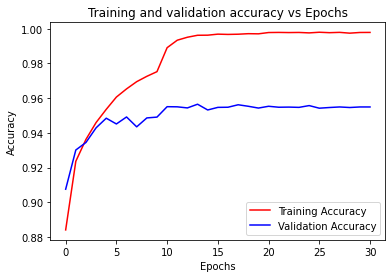

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


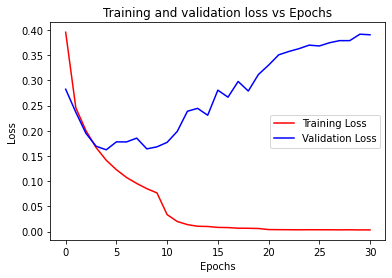

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


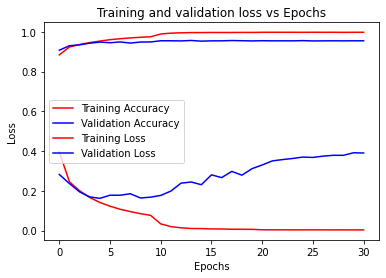

In [18]:
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']
epochs=range(len(acc))

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title('Training and validation accuracy vs Epochs')
plt.legend()
fig_name_eps = "accuracy.eps"
plt.savefig(os.path.join(char, fig_name_eps))
plt.show()


plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss vs Epochs')
plt.legend()
fig_name_eps = "loss.eps"
plt.savefig(os.path.join(char, fig_name_eps))
plt.show()

plt.plot(epochs, acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.plot(epochs, loss, 'r', label="Training Loss")
plt.plot(epochs, val_loss, 'b', label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title('Training and validation loss vs Epochs')
plt.legend()
fig_name_eps = "char.eps"
plt.savefig(os.path.join(char, fig_name_eps))

In [19]:
training_accuracy = train_score[1]*100
validation_accuracy = val_score[1]*100
test_accuracy = test_score[1]*100

print("The training accuracy is: " + str(training_accuracy) + ' %')
print("The validation accuracy is: " + str(validation_accuracy) + ' %')
print("The test accuracy is: " + str(test_accuracy) + ' %')

The training accuracy is: 99.7987151145935 %
The validation accuracy is: 95.53134441375732 %
The test accuracy is: 95.4444944858551 %


In [20]:
test_accuracy = train_score[1]*100
test_precision = train_score[2]*100
test_recall = train_score[3]*100
tp = int(train_score[4])
tn = int(train_score[5])
fp = int(train_score[6])
fn = int(train_score[7])

f1 = 2*((test_precision*test_recall)/(test_precision+test_recall))
sensitivity = (tp/(tp+fn))*100
specificity = (tn/(tn+fp))*100

In [21]:
test_accuracy = test_score[1]*100
test_precision = test_score[2]*100
test_recall = test_score[3]*100
tp = int(test_score[4])
tn = int(test_score[5])
fp = int(test_score[6])
fn = int(test_score[7])

f1 = 2*((test_precision*test_recall)/(test_precision+test_recall))
sensitivity = (tp/(tp+fn))*100
specificity = (tn/(tn+fp))*100

In [22]:
print("Test Accuracy: {}".format(test_accuracy))
print("Test Precision: {}".format(test_precision))
print("Test Recall: {}".format(test_recall))
print("True Positive: {}".format(tp))
print("Test Negetive: {}".format(tn))
print("False Positive: {}".format(fp))
print("False Negetive: {}".format(fn))
print("Sensitivity: {}".format(sensitivity))
print("Specificity: {}".format(specificity))

Test Accuracy: 95.4444944858551
Test Precision: 95.48183083534241
Test Recall: 95.43660283088684
True Positive: 12088
Test Negetive: 37426
False Positive: 572
False Negetive: 578
Sensitivity: 95.43660192641717
Specificity: 98.49465761355862


In [23]:
from contextlib import redirect_stdout

readme_name_text = "readme.txt"
print(f"Please read the text file named {readme_name_text} for detailed information of the model.")

completeName_txt = os.path.join(char, readme_name_text) 

readme = open(completeName_txt, "w")

if len(os.listdir(train_directory)) > 2:
    readme.write(f"This is a {len(os.listdir(train_directory))}-class CLASSIFICATION")
else:
    readme.write("This is a BINARY CLASSIFICATION")


readme.write("\n\n--HYPERPARAMETERS--\n")
readme.write(f"\nInitial Learning Rate = {learning_rate}")
readme.write(f"\nNo. of epochs = {len(acc)}")
readme.write(f"\nBatch Size = {batch_size}")


readme.write("\n\n--MODEL-PARAMETERS--")
readme.write(f"\nOptimizer = {optimizer}\n\n")


readme.write("Trained on a VGG16\n")
with redirect_stdout(readme):
    model.summary()
        
    
readme.write("\n\n--MODEL-PERFORMANCE--")
readme.write(f"\nTest Accuracy = {test_accuracy} %")
readme.write(f"\nTest Precision = {test_precision} %")
readme.write(f"\nTest Recall = {test_recall} %")
readme.write(f"\nTrue Positive = {tp}")
readme.write(f"\nTrue Negetive = {tn}")
readme.write(f"\nFalse Positive = {fp}")
readme.write(f"\nFalse Negetive = {fn}")
readme.write(f"\nSensitivity = {sensitivity}")
readme.write(f"\nSpecificity = {specificity}\n\n\n")


readme.write("\n\n--MODEL-CHARACTERISTICS--")
readme.write(f"\nacc = {acc}")
readme.write(f"\n\nval_acc = {val_acc}")
readme.write(f"\n\nloss = {loss}")
readme.write(f"\n\nval_loss = {val_loss}")


readme.write(f"\n\nExecution Time: {duration} seconds")

readme.write("\n\nCreated using Self-Regulated Image Classifier using Convolution Neural Network")

readme.close()

Please read the text file named readme.txt for detailed information of the model.
